## Face detection model
In this notebook we gonna to build the model to detect the face in images.

we use tensorflow to develop the convolutional model.

Model detected the (x, y , weight and height) to draw a rectangle around the face.

all images are resized to 64*64 in 3 channels(RGB).

I use the celeba dataset: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


In [1]:
# import libraries
import numpy as np
import os, re, cv2, psutil, sys, random
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

In [2]:
# read the box coordinates file
with open('./box_faces.txt', 'r') as f:
    bbox_content = f.read()

In [3]:
# hyperparameters
IMG_SIZE = (64, 64)
BUFFER_SIZE = 10_000
BATCH_SIZE=256
EPOCHS=100

In [4]:
# Set up a dictionary that has image paths and coordinates
bbox_crd = {}

for line in bbox_content.split('\n'):
    if line != '':
        img_name, coordinates = line.split('\t')
        if coordinates != 'None':
            coordinates = coordinates.split(' ')
            if len(coordinates) == 5:
                coordinates.pop(-1)

            coordinates = np.array(coordinates, dtype='int32')
        else:
            coordinates = np.nan
    
    bbox_crd[img_name] = coordinates
print(len(bbox_crd))

202599


In [5]:
# create the inputs and targets data for model
inputs = []
targets = []

for (main_path, _, imgs_path) in os.walk('./img_align_celeba'):
    for img_path in imgs_path[:BUFFER_SIZE]:
        coordinate = bbox_crd[img_path]

        if type(coordinate) == np.ndarray:
            assert len(coordinate) == 4
            img = cv2.imread(os.path.join(main_path, img_path))
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255

            inputs.append(img)
            targets.append(coordinate)

print('inputs length: {:,}, targets length: {:,}'.format(len(inputs), len(targets)))

inputs length: 9,518, targets length: 9,518


In [6]:
# convert the list data into tensor
inputs = tf.constant(inputs)
targets = tf.constant(targets)

print(inputs.shape, targets.shape)

(9518, 64, 64, 3) (9518, 4)


In [7]:
valid_inputs, valid_targets = [], []

for (main_path, _, imgs_path) in os.walk('/content/img_align_celeba'):
    for img_path in imgs_path[BUFFER_SIZE:BUFFER_SIZE+2000]:
        coordinate = bbox_crd[img_path]

        if type(coordinate) == np.ndarray:
            assert len(coordinate) == 4
            img = cv2.imread(os.path.join(main_path, img_path))
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255

            valid_inputs.append(img)
            valid_targets.append(coordinate)

print('inputs length: {:,}, targets length: {:,}'.format(len(valid_inputs), len(valid_targets)))

inputs length: 1,912, targets length: 1,912


In [8]:
valid_inputs = tf.constant(valid_inputs)
valid_targets = tf.constant(valid_targets)

print(valid_inputs.shape, valid_targets.shape)

(1912, 64, 64, 3) (1912, 4)


In [9]:
# create the dataset
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset = dataset.cache()
print(dataset)

<CacheDataset shapes: ((None, 64, 64, 3), (None, 4)), types: (tf.float64, tf.int32)>


### Build the model

In [10]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=inputs.numpy().shape[1:], kernel_initializer=glorot_uniform()))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=glorot_uniform()))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', activation='sigmoid', kernel_initializer=glorot_uniform()))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=glorot_uniform()))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform()))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform()))
model.add(Dropout(0.25))

model.add(Dense(16, activation='relu', kernel_initializer=glorot_uniform()))
model.add(Dropout(0.5))

model.add(Dense(4, kernel_initializer=glorot_uniform()))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0

In [11]:
# set 'adam' optimizer
adam = tf.keras.optimizers.Adam(learning_rate=1e-1)

# compile the model
model.compile(optimizer=adam, loss='MAE')

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

callbacks = [early_stopping]

In [13]:
# fit the model
history = model.fit(dataset, epochs=EPOCHS, validation_data=(valid_inputs, valid_targets), callbacks=callbacks)

Epoch 1/100
38/38 [==============================] - 8s 111ms/step - loss: 30913.6679 - val_loss: 76.0894
Epoch 2/100
38/38 [==============================] - 3s 89ms/step - loss: 75.0465 - val_loss: 72.2459
Epoch 3/100
38/38 [==============================] - 3s 89ms/step - loss: 71.2084 - val_loss: 68.4208
Epoch 4/100
38/38 [==============================] - 3s 89ms/step - loss: 67.3882 - val_loss: 64.6115
Epoch 5/100
38/38 [==============================] - 3s 89ms/step - loss: 63.5810 - val_loss: 60.8131
Epoch 6/100
38/38 [==============================] - 3s 89ms/step - loss: 59.7833 - val_loss: 57.0279
Epoch 7/100
38/38 [==============================] - 3s 89ms/step - loss: 56.0000 - val_loss: 53.2730
Epoch 8/100
38/38 [==============================] - 3s 90ms/step - loss: 52.2520 - val_loss: 49.6078
Epoch 9/100
38/38 [==============================] - 3s 90ms/step - loss: 48.6283 - val_loss: 46.1915
Epoch 10/100
38/38 [==============================] - 3s 91ms/step - loss: 45.

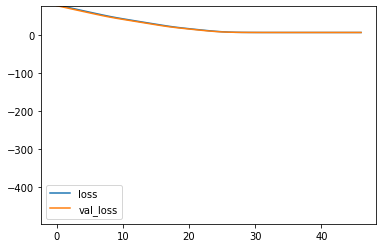

In [14]:
# plot the loss and validation loss 
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.ylim(top=max(loss[1:]))
plt.show()

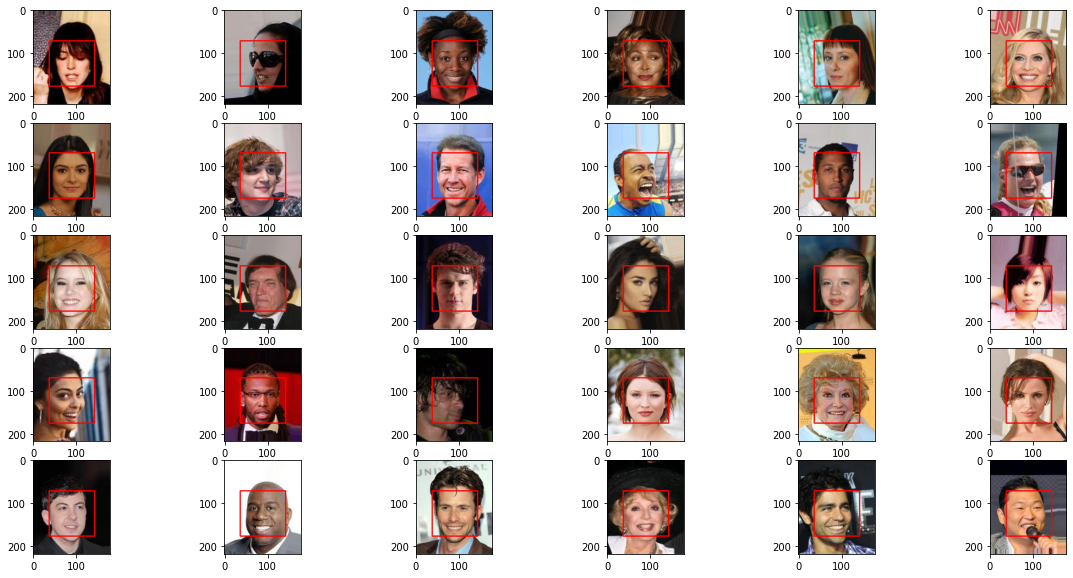

In [15]:
# predict some random images with the model that we just created
plt.figure(figsize=(20, 10))
for i in range(30):
    plt.subplot(5,6,i+1)
    sample_name = random.choice(imgs_path)
    sample_img = cv2.imread(os.path.join(main_path, sample_name))
    smp_img_show = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    sample_img = cv2.resize(sample_img, IMG_SIZE)
    sample_img = sample_img / 255
    sample_img = tf.expand_dims(sample_img, 0) 
    x, y, w, h = model(sample_img)[0]

    cv2.rectangle(smp_img_show, (x, y), (x+w, y+h), (255,0,0), 2)
    plt.imshow(smp_img_show)